In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download plameneduardo/sarscov2-ctscan-dataset/version/2

sarscov2-ctscan-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip sarscov2-ctscan-dataset.zip

Archive:  sarscov2-ctscan-dataset.zip
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COVID/Covid (1015).png  
  inflating: COVID/Covid (1016).png  
  inflating: COVID/Covid (1017).png  
  inflating: COVID/Covid (1018).png  
  inflating: COVID/Covid (1019).png  
  inflating: COVID/Covid (102).png   
  inflating:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '../content'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (576).png,0,COVID
1,COVID/Covid (418).png,0,COVID
2,COVID/Covid (168).png,0,COVID
3,COVID/Covid (61).png,0,COVID
4,COVID/Covid (455).png,0,COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (857).png,0,COVID
1,COVID/Covid (354).png,0,COVID
2,non-COVID/Non-Covid (148).png,1,non-COVID
3,non-COVID/Non-Covid (289).png,1,non-COVID
4,COVID/Covid (412).png,0,COVID


In [ ]:
import pandas_profiling as pp
pp.ProfileReport(train)

TypeError: ignored

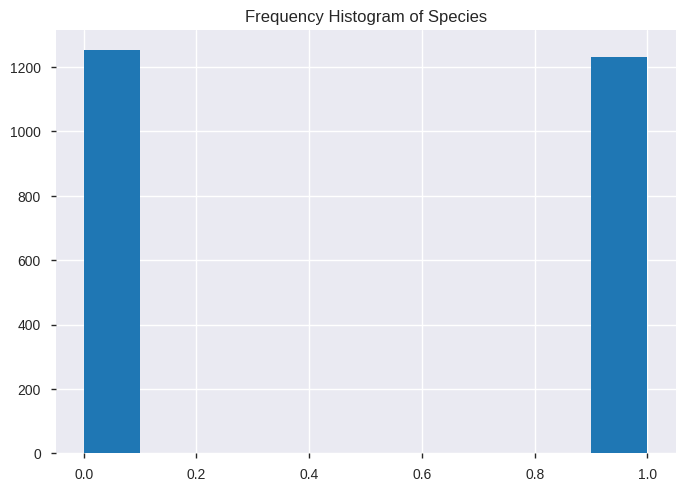

<Figure size 1200x1200 with 0 Axes>

In [ ]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

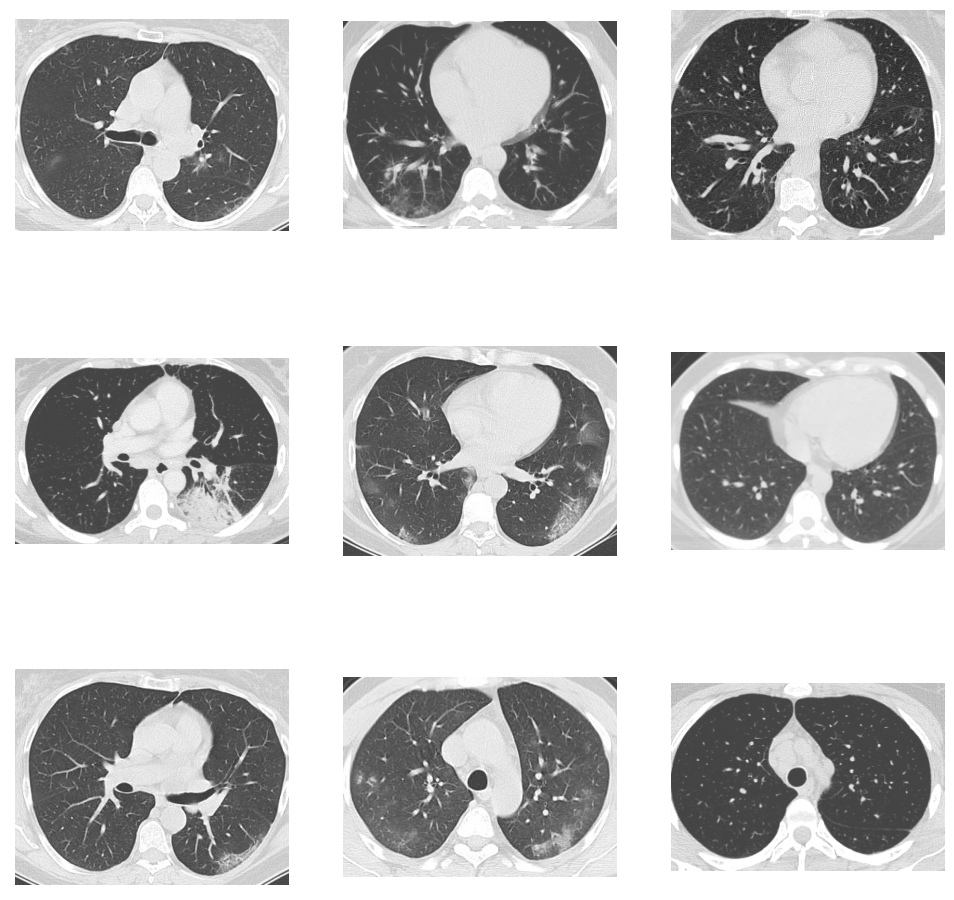

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)

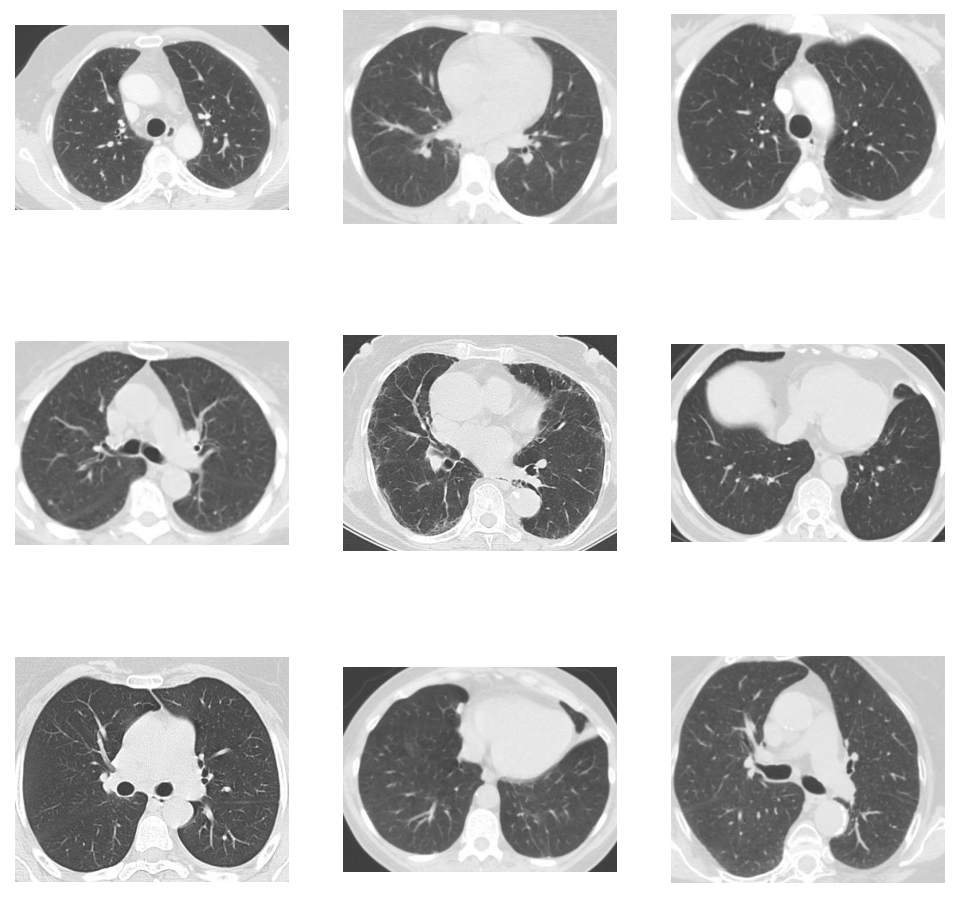

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 3, 3)

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:09, 273.52it/s]


Train Shape: (2481, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)


In [ ]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1984, 64, 64, 3)
X_val: (497, 64, 64, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


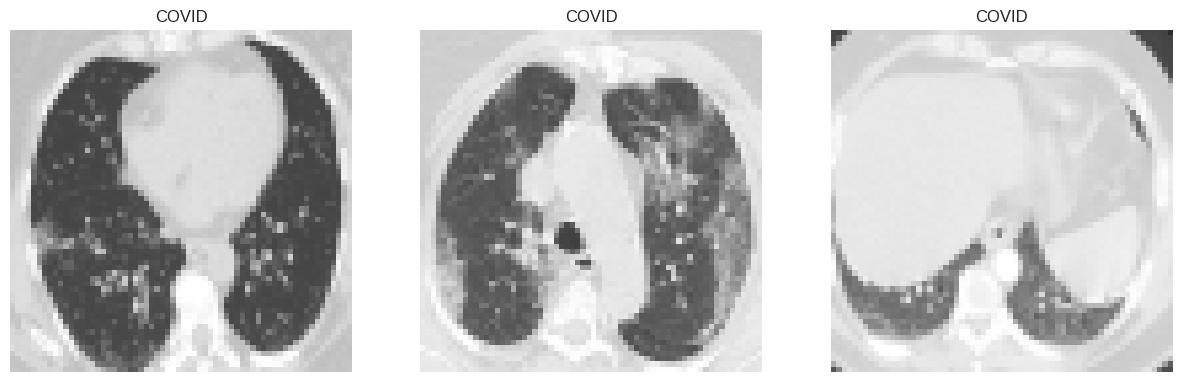

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

In [ ]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


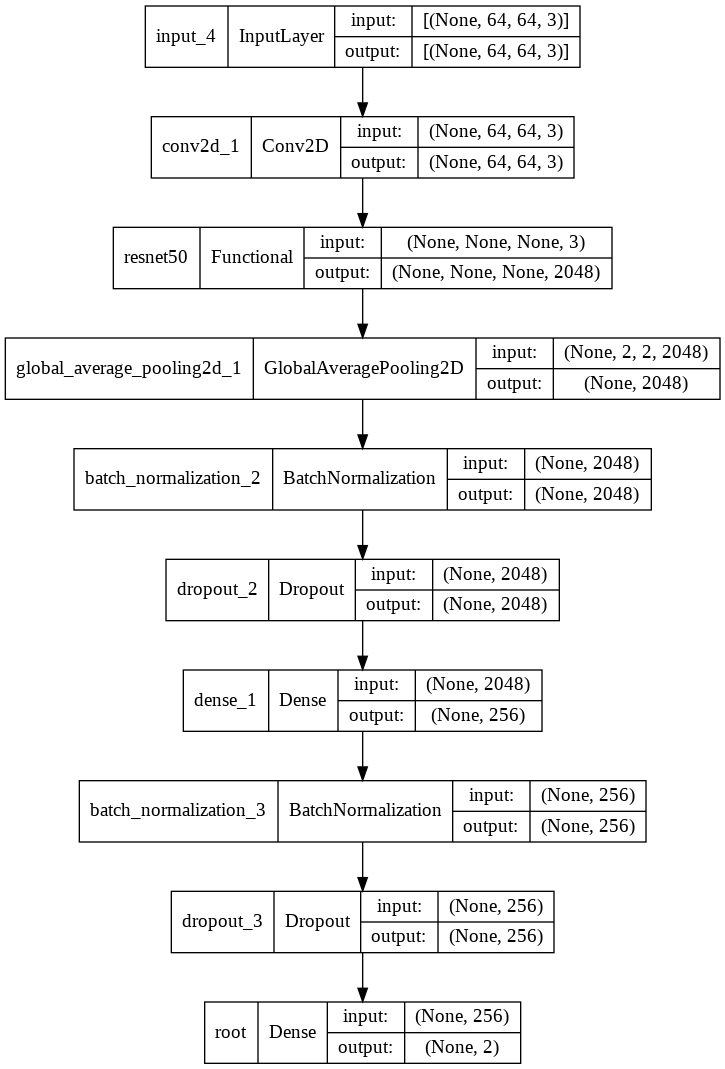

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.1426 - accuracy: 0.5418
Epoch 00001: val_loss improved from inf to 0.99766, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 281s 9s/step - loss: 1.1426 - accuracy: 0.5418 - val_loss: 0.9977 - val_accuracy: 0.4487 - lr: 0.0030
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.5887
Epoch 00002: val_loss did not improve from 0.99766
31/31 [==============================] - 271s 9s/step - loss: 0.9925 - accuracy: 0.5887 - val_loss: 7.6139 - val_accuracy: 0.4487 - lr: 0.0030
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.6210
Epoch 00003: val_loss did not improve from 0.99766
31/31 [==============================] - 281s 9s/step - loss: 0.8918 - accuracy: 0.6210 - val_loss: 3.8378 - val_accuracy: 0.4487 - lr: 0.0030
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.8334 - accuracy: 0.6381
Epoch 00004: val_loss did not improve from 0.99766
31/31 [==============================] - 275s 9s/step - loss: 0.8334 - accuracy: 0.6381 - val_loss: 16.9254 - val_accuracy: 0.5513 - lr:

In [ ]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 7s 447ms/step - loss: 0.2260 - accuracy: 0.9215
Final Loss: 0.22599758207798004, Final Accuracy: 0.9215291738510132


Text(0.5, 187.86111111111106, 'Predicted')

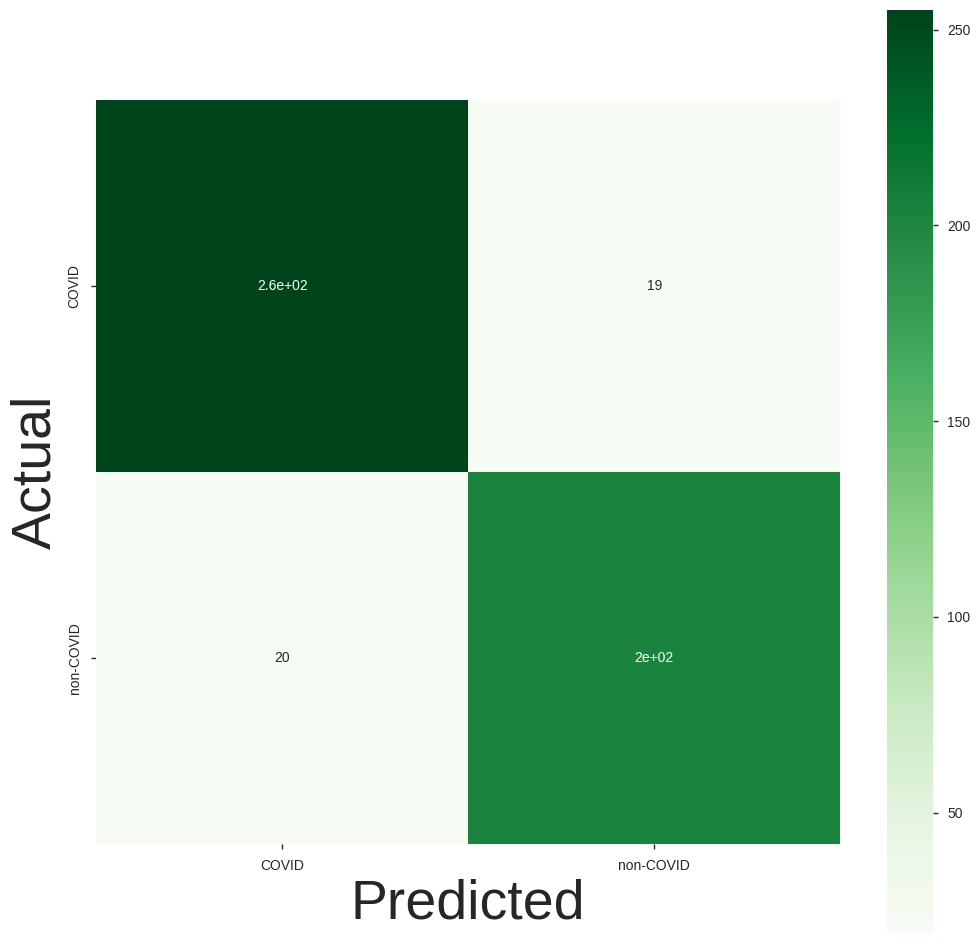

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

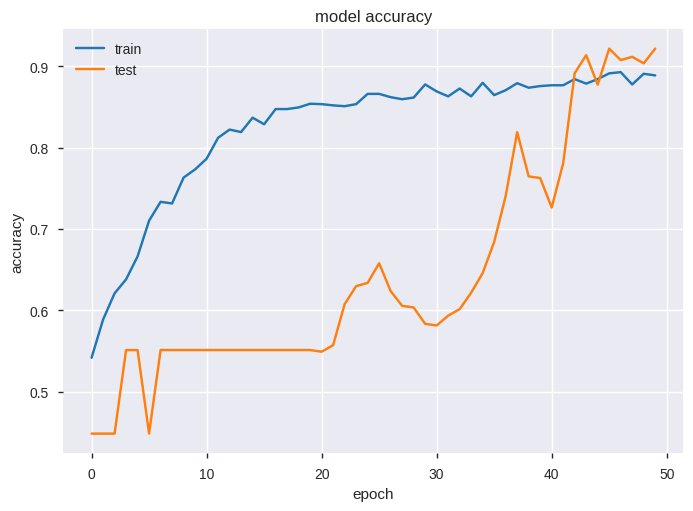

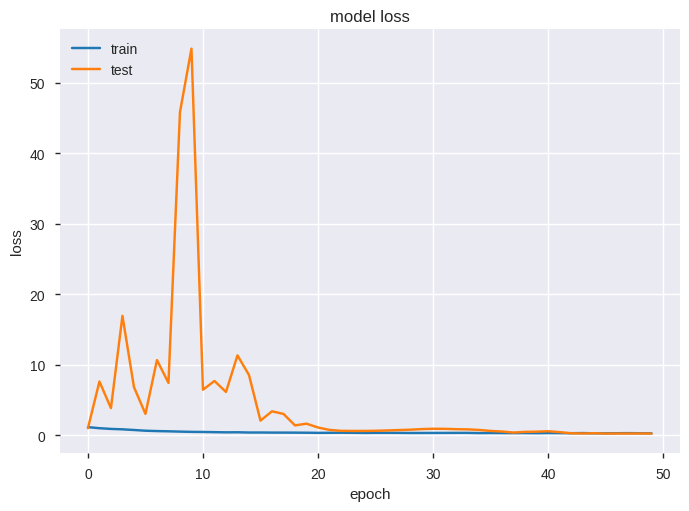

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[9.9988639e-01 1.1355758e-04]


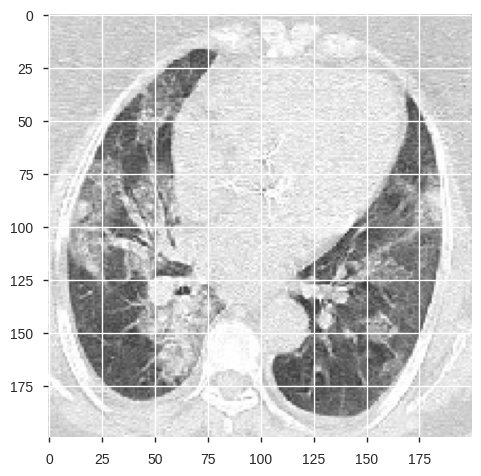

Prediction: Covid-19


In [ ]:
from skimage import io
from keras.preprocessing import image
img = image.load_img('../content/COVID/Covid (1014).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('../content/COVID/Covid (1014).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])